# Morphometrics

We will see how we can use any given surface from Badlands to extract several parameters relative to **morphometrics analysis**. The analysis relies only on the `tin` files (*i.e.* surface) produced by Badlands. If you are interested in looking at hydrometrics and stratigraphic analysis there are other notebooks specially designed for that in the **Badlands companion** repository.

**Morphometrics** refers to quantitative description and analysis of the produced Badlands landforms which could be applied to a particular kind of landform or to drainage basins and large regions.

The following suite of geomorphic attributes could be extracted:
- **gradient**: magnitude of maximum gradient
- **horizontal curvature** describes convergent or divergent fluxes
- **vertical curvature**: positive values describe convex profile curvature, negative values concave profile.
- **aspect**: direction of maximum gradient
- **discharge**:  it relates to the drainage area

In addition, the last section of this notebook shows how you can `slice` the model in any direction to plot a **profile** of the elevation.

In [4]:
%matplotlib inline

# Import badlands grid generation toolbox
from scripts import morphoGrid as morph

# display plots in SVG format
%config InlineBackend.figure_format = 'svg' 

from matplotlib import pyplot as plt
import numpy as np

# 1. Define analyse bounding box

We first have to define the path to the Badlands outputs we want to analyse. In addition Badlands is creating several files for each processors that have been used, you need to specify this number in the `ncpus` variable. 

We then need to provide the extent of the area we want to perform morphometrics analysis on using the `bbox` parameters which is numpy array containing the extent in the following order [xlow,ylow,xup,yup]. 

Finally you need to specify the resolution you want to work on. Usually Badlands model are ran on resolution of several hundred of metres but you might want to extract the morphemetrics attributes at a much higher resolution. This is done using the `dx` parameter which is in metres.

For more information regarding the function uncomment the following line.

In [5]:
#help(morph.morphoGrid.__init__)

In [9]:
morpho = morph.morphoGrid(folder='output_glacier_2/h5', bbox = [20000,0,60000,40000], dx=50)

# 2. Interpolation of TIN data

We now interpolate the data from a particular time step (`timestep`) from the TIN to the regular grid, which extent and resolution have been specified in previous function.

**Note**

If you are interested in making some morphometric comparisons between different time steps you could create multiple instances of the morphometrics python class each of them associated to a given time step.

In [10]:
#help(morpho.loadHDF5)

Here you can specify which timestep to explore:

In [11]:
morpho.loadHDF5(timestep=20)

## 2.1 Plot the elevation data

Now we can plot the elevation using morpho.z, which takes the Z axis value from the TIN file and is able to plot it on the regualr grid.

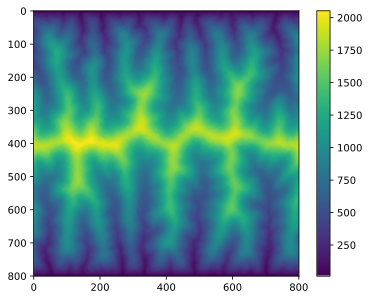

In [20]:
plt.imshow(morpho.z)
plt.colorbar()

# 3. Cross-sections analyses

The last function provided here helps you to create a cross-section from 2 points (xo,yo) and (xm,ym). The create section will interpolate the attributes over the desired slice using a bivariate spline method. 

The resulting section is then plotted as a 2D scatter and line graph using **plotly** library.

In [21]:
# Number of cross-sections
nbCS = 40
# Number of points per cross-section
nbPts = 401
# Extent of the cross-section along Y-axis
ymin = 0.
ymax = 40000.
# Extent of the cross-section along X-axis
xmin = 24000.
xmax = 57000.
# Define timestep and according time interval based on display time in the XML input file
timeStp = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
timeMA = list(map(lambda x: x * 0.25, timeStp))

Now that we have defined the parameters we use the following loop to create the averaged representation at each time step of the landscape along the combined cross-section (based on mean, max & min values)

For more information regarding the functions used here uncomment the following line.

In [22]:
#help(morpho.extractSection)
#help(morpho.statProfiles)

In [23]:
xlist = [None] * nbCS
zlist = np.zeros((nbCS,nbPts))
dx = (xmax - xmin)/(nbCS-1)

zmin = np.zeros((len(timeStp),nbPts))
zmean = np.zeros((len(timeStp),nbPts))
zmax = np.zeros((len(timeStp),nbPts))

for t in range(len(timeStp)):
    step = timeStp[t]
    morpho.loadHDF5(timestep=step)

    for i in range(0,nbCS):
        xlist[i] = xmin+i*dx
        dist, zlist[i,:] = morpho.extractSection(xo = xlist[i], yo = ymin, xm = xlist[i], ym = ymax, pts = nbPts, vData = morpho.z, 
                   view = False, width = 800, height = 400, color = 'black', linesize = 3, 
                   markersize = 1, title = 'Cross section %d'% step)
    if timeMA[t] > 15.: 
        color = 'rgba(104, 192, 98, 0.4)'
    else:
        color = 'rgba(243, 133, 79, 0.4)'
    zmin[t,:], zmean[t,:], zmax[t,:] = morpho.statProfiles(pData = zlist, pDist = dist, width = 1000, height = 500, 
                   color = color, linesize = 3, title = 'Analyse sections time %5.2f Ma' %timeMA[t])

# 4. Time evolution

We can then visualise the averaged profiles through time on a single graph:

In [24]:
#help(morpho.timeProfiles)

In [25]:
morpho.timeProfiles(pData = zmean, pDist = dist, width = 1000, height = 600, linesize = 3,
                    title = 'Profiles evolution with time')

## 4.1. Evolution of profile elevation with time

We can create other plots for example the evolution of the maximum value of the min, mean, & max profile through time.

In [15]:
zz = np.zeros((3,len(timeStp)))

zz[0,:] = np.amax(zmin, axis=1)
zz[1,:] = np.amax(zmean, axis=1)
zz[2,:] = np.amax(zmax, axis=1)

In [16]:
morpho.timeProfiles(pData = zz, pDist = timeMA, width = 800, height = 500, linesize = 3,
                    title = 'Averaged Evolution through Time')

# 4.2. Position of maximum profiles along an axis

Or the position of a given value from the different profiles with time.

In [17]:
zpos = np.zeros((3,len(timeStp)))
zpos[0,:] = dist[np.argmax(zmin, axis=1)] / (ymax-ymin)
zpos[1,:] = dist[np.argmax(zmean, axis=1)] / (ymax-ymin)
zpos[2,:] = dist[np.argmax(zmax, axis=1)] / (ymax-ymin)

In [18]:
morpho.timeProfiles(pData = zpos, pDist = timeMA, width = 1000, height = 600, linesize = 3,
                    title = 'Position of min, mean & max profile through Time')